# Resume Classifcation Model using NLP


Dataset : https://www.kaggle.com/gauravduttakiit/resume-dataset
 

In [193]:
# importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

import re
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

In [194]:
df = pd.read_csv('./dataset/UpdatedResumeDataSet.csv')

# df = pd.read_csv('./dataset/Resume.csv')
# df.drop(columns=['ID', 'Resume_html'], inplace=True)
# df.rename(columns={'Resume_str':'Resume'}, inplace=True)

df.head()

,Category,Resume
0,Data Science,Skills * Programming Languages: Python (pandas...
1,Data Science,Education Details \r\nMay 2013 to May 2017 B.E...
2,Data Science,"Areas of Interest Deep Learning, Control Syste..."
3,Data Science,Skills â¢ R â¢ Python â¢ SAP HANA â¢ Table...
4,Data Science,"Education Details \r\n MCA YMCAUST, Faridab..."


# 1. Exploratory Data Analysis (EDA)

In [195]:
# checking duplicated
# df.drop_duplicates(inplace=True)
# df.duplicated().sum()

In [196]:
category = df['Category'].value_counts().reset_index()
category.rename(columns={'index':'job', 'Category':'count'}, inplace=True)
category.head()

,job,count
0,Java Developer,84
1,Testing,70
2,DevOps Engineer,55
3,Python Developer,48
4,Web Designing,45


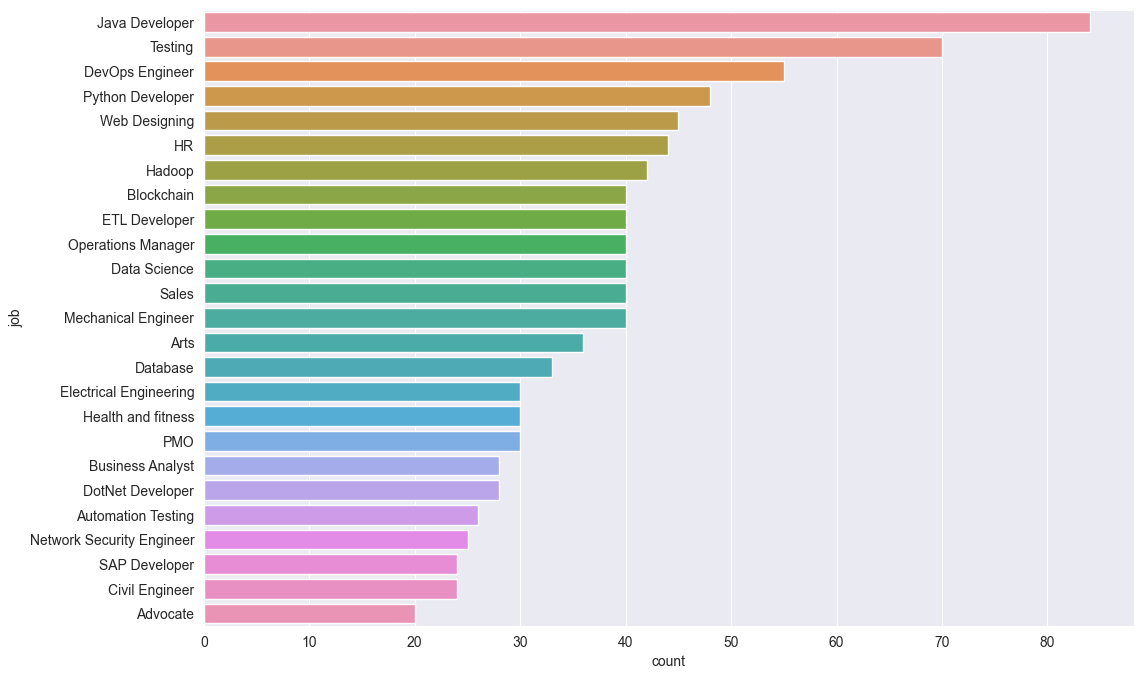

In [197]:
plt.figure(figsize=(12,8))
sns.barplot(x=category['count'], y=category['job'])
plt.show()

# 2) Data Pre-processing

In [198]:
# Importing NLP tools
import spacy # for lemmatization
nlp = spacy.load('en_core_web_sm')

import re   # regex
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
nltk.download('punkt') # for word_tokenize
nltk.download('stopwords') # for stopwords

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\wish6\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\wish6\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Data cleaning

In [199]:
def clean(text):
    text = text.lower()

    text = re.sub('^[\w\-\.]+@([\w-]+\.)+[\w-]{2,4}', ' ', text)  # remove email
    text = re.sub('[(http(s)?):\/\/(www\.)?a-zA-Z0-9@:%._\+~#=]{2,256}\.[a-z]{2,6}\b([-a-zA-Z0-9@:%_\+.~#\?&//=]*)', ' ', text)  # remove URLs
    text = re.sub('<.+?>', ' ', text)  # html tags
    text = re.sub('[^a-z]', ' ', text) # remove non-characters
    text = re.sub('\s+', ' ', text)  # remove extra whitespace

    doc = nlp(text) # change text into DOC object
    text = ' '.join([token.lemma_ for token in doc]) # lemmatization
     
    text = text.lower() # to lowercase again
     
    text = word_tokenize(text) # tokenize word into list again
    
    stop_words = set(stopwords.words('english')) # get stopwords
    text = [word for word in text if word not in stop_words] # remove stop words
    
    return ' '.join(text)

In [200]:
clean("I'm sly king of the fly.") # example after cleaning

'sly king fly'

In [201]:
df['cleaned'] = df['Resume'].apply(lambda x : clean(x)) # apply clean to all resume

In [202]:
df.head()

,Category,Resume,cleaned
0,Data Science,Skills * Programming Languages: Python (pandas...,skill programming language python panda numpy ...
1,Data Science,Education Details \r\nMay 2013 to May 2017 B.E...,education detail may may b e uit rgpv data sci...
2,Data Science,"Areas of Interest Deep Learning, Control Syste...",area interest deep learning control system des...
3,Data Science,Skills â¢ R â¢ Python â¢ SAP HANA â¢ Table...,skill r python sap hana tableau sap hana sql s...
4,Data Science,"Education Details \r\n MCA YMCAUST, Faridab...",education detail mca ymcaust faridabad haryana...


In [203]:
# corpus is all the texts in the dataset
corpus = ""
for resume in df['cleaned']:
    corpus += resume

print(f'Corpus string length: {len(corpus)}')

Corpus string length: 2306347


In [204]:
corpus_tokens = word_tokenize(corpus) # tokenize word in corpus

word_freq = nltk.FreqDist(corpus_tokens) # get frequency of each word
mostcommon = word_freq.most_common(30) # get top 30 common words

common = pd.DataFrame(mostcommon)
common.rename(columns={0:'word', 1:'frequency'}, inplace = True)
common.head()

,word,frequency
0,project,4059
1,exprience,3829
2,company,3635
3,month,3244
4,detail,3039


<AxesSubplot: title={'center': 'Most common words'}, xlabel='frequency', ylabel='word'>

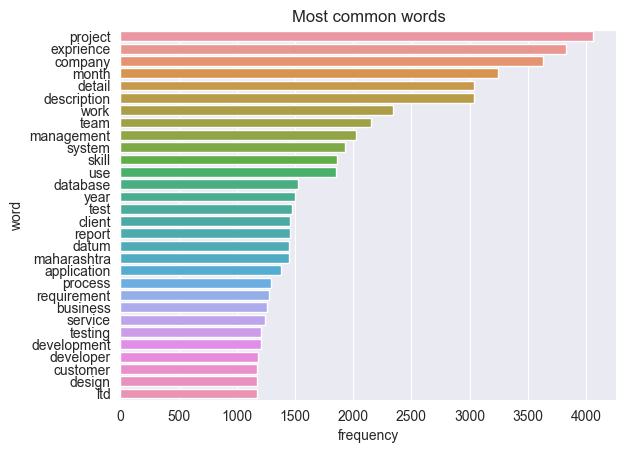

In [205]:
plt.title('Most common words')
sns.barplot(common, x='frequency', y='word')


Label Encoding

In [206]:
# Label Encoding
le = LabelEncoder()
df['Category_ID'] = le.fit_transform(df['Category'])

for i,v in enumerate(le.classes_):
    print(f'{i} : {v}')

0 : Advocate
1 : Arts
2 : Automation Testing
3 : Blockchain
4 : Business Analyst
5 : Civil Engineer
6 : Data Science
7 : Database
8 : DevOps Engineer
9 : DotNet Developer
10 : ETL Developer
11 : Electrical Engineering
12 : HR
13 : Hadoop
14 : Health and fitness
15 : Java Developer
16 : Mechanical Engineer
17 : Network Security Engineer
18 : Operations Manager
19 : PMO
20 : Python Developer
21 : SAP Developer
22 : Sales
23 : Testing
24 : Web Designing


Vectorizing (Feature Extraction)

In [207]:
# Vectorizing the cleaned columns
cleaned = df['cleaned'].to_numpy()
Category_ID = df['Category_ID'].to_numpy()

word_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    stop_words='english',
    max_features=1500)

word_vectorizer.fit(cleaned)
WordFeatures = word_vectorizer.transform(cleaned)

In [208]:
WordFeatures.shape

(962, 1500)

# Model Building

In [209]:
# split training and testing set
X_train, X_test, y_train, y_test = train_test_split(WordFeatures, Category_ID, random_state=42, test_size=0.2)

In [210]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((769, 1500), (193, 1500), (769,), (193,))

In [211]:
# Model Training
model = OneVsRestClassifier(KNeighborsClassifier())
model.fit(X_train, y_train)

OneVsRestClassifier(estimator=KNeighborsClassifier())

In [212]:
# Prediction
y_pred = model.predict(X_test)

In [213]:
print(f'---------------------------------\n| Training Accuracy   :- {(model.score(X_train, y_train)*100).round(2)}% |')
print(f'---------------------------------\n| Validation Accuracy :- {(model.score(X_test, y_test)*100).round(2)}% |\n---------------------------------')

---------------------------------
| Training Accuracy   :- 99.09% |
---------------------------------
| Validation Accuracy :- 98.45% |
---------------------------------


In [214]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         5
           3       1.00      1.00      1.00         7
           4       1.00      1.00      1.00         4
           5       1.00      1.00      1.00         9
           6       1.00      0.60      0.75         5
           7       1.00      1.00      1.00         8
           8       1.00      0.93      0.96        14
           9       1.00      1.00      1.00         5
          10       1.00      1.00      1.00         7
          11       1.00      1.00      1.00         6
          12       1.00      1.00      1.00        12
          13       1.00      1.00      1.00         4
          14       1.00      1.00      1.00         7
          15       1.00      1.00      1.00        15
          16       1.00      1.00      1.00         8
          17       1.00    